In [4]:
import duckdb

# set which database file to use
#db_file = "databases/pt.duckdb"
db_file = "databases/sync.duckdb"

# set up the moving average
window_size=250

# load the time bounds and figure out where our plots should focus.
with duckdb.connect(db_file) as con:
    with open("sql/timestamped_ranges.sql") as script:
        sql_script = script.read()
    [con.execute(s) for s in con.extract_statements(sql_script)]

    # set the time bounds
    # calculate ipc over buckets
    #start_ns, end_ns = 4472714308357, 4472714316324

    con.execute('''--sql
SELECT min(end_time)
FROM timestamped_ranges
WHERE end_time > 0
;''')
    first_time = con.fetchone()[0]

    con.execute('''--sql
SELECT max(end_time)
FROM timestamped_ranges
;''')
    last_time = con.fetchone()[0]

    start_ns = int(first_time + ((last_time - first_time) / 2))
    duration_ns = 15_000
    end_ns = start_ns + duration_ns

    con.execute('''--sql
CREATE OR REPLACE TABLE time_bounds AS
SELECT
    col0 AS ns,
    (SELECT MIN(end_cum_cyc)
        FROM timestamped_ranges
        WHERE end_time > col0
        ) AS cyc
FROM (VALUES ({}), ({}))
;'''.format(start_ns, end_ns))

    con.execute('''--sql
SELECT cyc
FROM time_bounds
ORDER BY cyc
;''')
    range_data = con.fetchall()
    start_cycles = range_data[0][0]
    end_cycles = range_data[1][0]

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [2]:
import duckdb

# perform data preparation.  This makes faster to work on plots so that each
# attempt doesn't have to wait for queries
with duckdb.connect(db_file) as con:
    # locate syscalls
    with open("sql/callstacks.sql") as script:
        text = script.read()
        sql_script = text.format(**{
            "start_ns": start_ns,
            "end_ns": end_ns,
        })
    [con.execute(s) for s in con.extract_statements(sql_script)]

    with open('sql/cdf.sql') as script:
        sql_script = script.read()
    [con.execute(s) for s in con.extract_statements(sql_script)]

    con.execute('''--sql
-- first treat this point as the leading edge of the sliding window
-- duckdb is incorrectly pushing filters into the ASOF join and then giving an error.
-- materialize this in a temp table and then filter that.
CREATE OR REPLACE TABLE sliding_window AS
with t1 as (
    SELECT
        leading_ranges.end_cum_cyc = trailing_ranges.end_cum_cyc AS is_single_range,

        leading_ranges.end_cum_cyc   AS window_end_cum_cyc,
        window_end_cum_cyc - ({window_size} - 1) AS window_start_cum_cyc,
        leading_ranges.end_time AS end_time,

        leading_ranges.end_cum_cyc   AS leading_end_cum_cyc,
        leading_ranges.cyc_count     AS leading_cyc_count,
        leading_ranges.end_cum_insns AS leading_end_cum_insns,
        leading_ranges.insn_count    AS leading_insn_count,

        trailing_ranges.end_cum_cyc   AS trailing_end_cum_cyc,
        trailing_ranges.cyc_count     AS trailing_cyc_count,
        trailing_ranges.end_cum_insns AS trailing_end_cum_insns,
        trailing_ranges.insn_count    AS trailing_insn_count,

        'leading' AS side,
        -- aliased implies that constructing spans from the other endpoint (the
        -- other side of the UNION ALL) will create the same span and so we must
        -- account for duplicates.
        window_start_cum_cyc = trailing_end_cum_cyc AS is_span_aliased,
    FROM 
        timestamped_ranges AS leading_ranges
        ASOF LEFT JOIN timestamped_ranges AS trailing_ranges
            -- looking for the range overlapping the trailing window
            -- if trailing.end_cum_cyc=leading_ranges.end_cum_cyc we have perfect alignment,
            -- otherwise there is some overlap
            ON trailing_ranges.end_cum_cyc > (leading_ranges.end_cum_cyc - {window_size})

    UNION ALL

    -- now treat this point as the trailing edge of the window
    -- we synthesize a transition point
    SELECT
        -- cannot happen as the next cycle is introducing a new range and span,
        -- by definition
        FALSE AS is_single_range,

        trailing_ranges.end_cum_cyc + {window_size} - 1 AS window_end_cum_cyc,
        trailing_ranges.end_cum_cyc AS window_start_cum_cyc,
        leading_ranges.end_time AS end_time,

        leading_ranges.end_cum_cyc   AS leading_end_cum_cyc,
        leading_ranges.cyc_count     AS leading_cyc_count,
        leading_ranges.end_cum_insns AS leading_end_cum_insns,
        leading_ranges.insn_count    AS leading_insn_count,

        trailing_ranges.end_cum_cyc   AS trailing_end_cum_cyc,
        trailing_ranges.cyc_count     AS trailing_cyc_count,
        trailing_ranges.end_cum_insns AS trailing_end_cum_insns,
        trailing_ranges.insn_count    AS trailing_insn_count,

        'trailing' AS side,
        -- aliased implies that constructing spans from the other endpoint (the
        -- other side of the UNION ALL) will create the same span and so we must
        -- account for duplicates.
        window_end_cum_cyc = leading_end_cum_cyc AS is_span_aliased,
    FROM 
        timestamped_ranges AS trailing_ranges
        ASOF JOIN timestamped_ranges AS leading_ranges
            -- now treat the trailing_ranges as the trailing edge of the window
            ON leading_ranges.end_cum_cyc >= (trailing_ranges.end_cum_cyc + {window_size} - 1)
)
SELECT
    *
FROM t1
-- BUG: it tries to push this into the ASOF JOIN and then concludes that it is
-- an invalid ASOF JOIN condition.
--
-- 1. semantically, WHERE should apply after FROM/JOIN, so it is not a condition on the join
-- 2. if applied in an outer query block it clearly has no relation to the join.
-- so I believe the filter is getting incorrectly pushed into the join.
--WHERE
--    side='leading' OR
--    -- the first SELECT of the UNION ALL already produced this point
--    trailing_end_cum_cyc <> leading_end_cum_cyc - {window_size}
;'''.format(
    window_size=window_size
    ))

    con.execute('''--sql
CREATE OR REPLACE TABLE ipc_spans AS
with t1 as (
    SELECT
        *
    FROM sliding_window
    WHERE NOT (side = 'trailing' AND is_span_aliased)
), t2 as (
    -- calculate instructions and cycles as of the last (latest/leading edge)
    -- window in this span
    --
    -- calculate for the leading, trailing, and interior ranges separately
    -- this gives us a slope of the linear interp IPC for the period ending at
    -- leading_end_cum_cyc
    -- it also gives us the optimistic and conservative IPC over that same span
    SELECT
        *,

        trailing_insn_count AS trailing_insns,
        -- number of cycles from the trailing sample that fall within the window
        trailing_end_cum_cyc - window_start_cum_cyc + 1 AS trailing_cyc_in_window,

        -- if the entire window is contained within a single sample we will call
        -- this the trailing edge and leave the leading edge 0 to make sure we
        -- don't double-count
        IF(is_single_range,
            0,
            leading_insn_count
            ) AS leading_insns,
        -- number of cycles from the leading sample that fall within the window
        IF(is_single_range,
            0,
            leading_cyc_count - (leading_end_cum_cyc - window_end_cum_cyc)
            ) AS leading_cyc_in_window,

        IF(is_single_range,
            0,
            (leading_end_cum_insns - leading_insn_count) - trailing_end_cum_insns
            ) AS interior_insns,
        IF(leading_end_cum_cyc = trailing_end_cum_cyc,
            0,
            (leading_end_cum_cyc - leading_cyc_count) - trailing_end_cum_cyc
            ) AS interior_cyc,

        CAST(trailing_insns + leading_insns + interior_insns as real) / ({window_size}) AS optimistic_ipc,
        CAST(interior_insns as real) / ({window_size}) AS conservative_ipc,
        (
            (trailing_insns * (CAST(trailing_cyc_in_window as real) / trailing_cyc_count)) +
            (leading_insns * (CAST(leading_cyc_in_window as real) / leading_cyc_count)) +
            interior_insns
        ) / ({window_size}) AS end_linear_interp_ipc,
    FROM t1
), t3 as (
    SELECT
        *,
        -- pandas casts any column containing null to float because it treats it as NaN.
        -- wtf who uses this shit.  A missing integer is perfectly reasonable
        COALESCE(
            window_end_cum_cyc - LAG(window_end_cum_cyc, 1) OVER (
                ORDER BY window_end_cum_cyc),
            0
            ) AS span_width_cyc,
    FROM t2
)
SELECT
    -- things needed for plotting
    -- casting to bigint as duckdb infers huge ints (int128) which pandas does
    -- not support and so casts to floats
    CAST(window_end_cum_cyc AS bigint) AS window_end_cum_cyc,
    CAST(window_start_cum_cyc AS bigint) AS window_start_cum_cyc,
    CAST(end_time AS ubigint) AS end_time,
    conservative_ipc,
    optimistic_ipc,
    -- make it stand out if this is missing due to division by 0
    coalesce(end_linear_interp_ipc, 10000.0) AS end_linear_interp_ipc,

    CAST(span_width_cyc AS bigint) AS span_width_cyc,
    CAST(window_end_cum_cyc - span_width_cyc AS bigint) AS span_start_cyc,

    -- helpful for debugging
    leading_cyc_in_window,
    leading_cyc_count,
    leading_insns,
    trailing_cyc_in_window,
    trailing_cyc_count,
    trailing_insns,
    interior_cyc,
    interior_insns,

    leading_end_cum_cyc,
    leading_end_cum_insns,
    leading_cyc_count,
    leading_insn_count,

    trailing_end_cum_cyc,
    trailing_end_cum_insns,
    trailing_cyc_count,
    trailing_insn_count,
FROM t3
ORDER BY window_end_cum_cyc
;'''.format(window_size=window_size))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

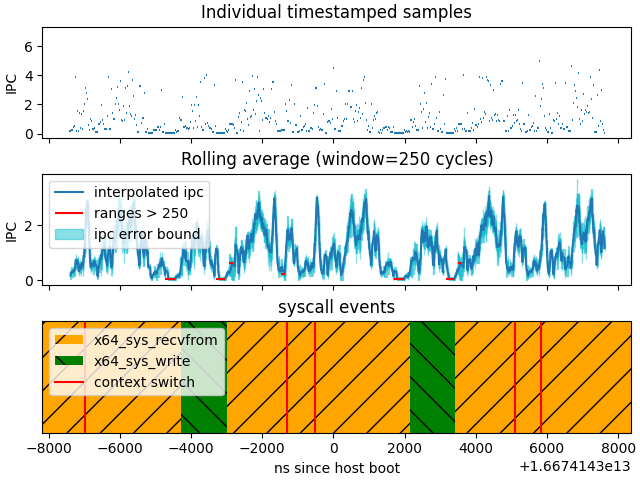

In [6]:
from matplotlib import pyplot as plt
import matplotlib
import duckdb
import collections
%matplotlib widget

with duckdb.connect(db_file) as con:
    # convert cyc to fractional ns and get the cyc time bounds
    con.execute('''--sql
SELECT ns, cyc
FROM time_bounds
ORDER BY cyc
;''')
    data = con.fetchall()
    (start_ns, start_cyc) = data[0]
    (end_ns, end_cyc) = data[1]
    ns_rate = float(end_ns - start_ns) / (end_cyc - start_cyc)

    def duration_cyc_to_ns(duration_cyc):
        return duration_cyc * ns_rate
    def time_cyc_to_ns(cyc):
        return start_ns + duration_cyc_to_ns(cyc - start_cyc)

    plt.close()
    fig, (ax1, ax2, ax3) = plt.subplots(
        nrows=3,
        sharex=True,
        layout='constrained')

    # plot 1: raw timestamped ranges
    con.execute('''--sql
SELECT
    start_cum_cyc,
    end_cum_cyc,
    cast(insn_count as real) / cyc_count as ipc,
    cyc_count,
FROM timestamped_ranges
WHERE end_cum_cyc BETWEEN {} AND {}
order by end_cum_cyc
;'''.format(start_cyc, end_cyc))
    range_data = con.df()
    range_data['start_ns'] = time_cyc_to_ns(range_data['start_cum_cyc'])
    range_data['end_ns'] = time_cyc_to_ns(range_data['end_cum_cyc'])
    ax1.hlines(
        y='ipc',
        xmin='start_ns',
        xmax='end_ns',
        data=range_data,
    )
    ax1.set_title('Individual timestamped samples')
    ax1.set_ylabel('IPC')

    # plot 2: rolling average and error bounds
    con.execute('''--sql
SELECT *
FROM ipc_spans
WHERE window_end_cum_cyc BETWEEN {} AND {}
ORDER BY window_end_cum_cyc
;'''.format(start_cyc, end_cyc))
    span_data = con.df()
    span_data['end_ns'] = time_cyc_to_ns(span_data['window_end_cum_cyc'])

    plot_handle = ax2.plot(
        'end_ns',
        'end_linear_interp_ipc',
        data=span_data,
        label='interpolated ipc')

    # plot the ipc range rectangles
    span_data['span_start_ns'] = time_cyc_to_ns(span_data['span_start_cyc'])
    span_data['span_width_ns'] = duration_cyc_to_ns(span_data['span_width_cyc'])
    span_data['ipc_range'] = span_data['optimistic_ipc'] - span_data['conservative_ipc']

    patches = []
    for index, row in span_data.iterrows():
        patches.append(matplotlib.patches.Rectangle(
            (row['span_start_ns'], row['conservative_ipc'],),
            row['span_width_ns'],
            row['ipc_range'],
        ))
    patches_collection = matplotlib.collections.PatchCollection(
        patches,
        alpha=0.5,
        color='tab:cyan')
    ax2.add_collection(patches_collection)
    proxy_patch = matplotlib.patches.Patch(
        alpha=0.5,
        color='tab:cyan',
        label='ipc error bound')

    # draw in individual ranges with durations exceeding some threshold
    range_data['start_ns'] = time_cyc_to_ns(range_data['start_cum_cyc'])
    range_data['end_ns'] = time_cyc_to_ns(range_data['end_cum_cyc'])

    cyc_limit=window_size
    long_range_data = range_data[range_data.cyc_count > cyc_limit]
    hlines_handle = ax2.hlines(
        y='ipc',
        xmin='start_ns',
        xmax='end_ns',
        data=long_range_data,
        color='r',
        label='ranges > {}'.format(cyc_limit),
    )
    ax2.set_title('Rolling average (window={} cycles)'.format(window_size))
    ax2.set_ylabel('IPC')
    ax2.legend(
        handles=[plot_handle[0], hlines_handle, proxy_patch],
    )

    con.execute('''--sql
SELECT
    call_time,
    return_time,
    syscall_kernel_name,
FROM syscall_calls
WHERE
    (call_time BETWEEN {start_ns} AND {end_ns})
    OR (return_time BETWEEN {start_ns} AND {end_ns})
ORDER BY syscall_kernel_name
;'''.format(end_ns=end_ns, start_ns=start_ns))
    event_data = con.fetchall()
    
    d = collections.defaultdict(list)
    for t in event_data:
        label=t[2].lstrip('_')
        d[label].append(t[0:2])
    labels=[]
    handles=[]
    hatches = ['/', '\\', 'x']
    colors = ['orange', 'green', 'blue', 'red']
    span_type_count=0
    for label, spans in d.items():
        labels.append(label)
        for i, span in enumerate(spans):
            handle=ax3.axvspan(
                xmin=span[0],
                xmax=span[1],
                facecolor=colors[span_type_count % len(colors)],
                hatch=hatches[span_type_count % len(hatches)]
                )
            if i == 0:
                handles.append(handle)
        span_type_count += 1

    # find and plot overflow errors
    con.execute(
'''--sql
-- duckdb incorrectly pushes predicates into the ASOF join, where they join the
-- left table to the incorrect rows of the right table instead of filtering
-- those rows.  Create a temp table and then filter later instead
CREATE TEMP TABLE errors_and_ranges AS
SELECT
    ae.time,
    tr.start_time,
    tr.start_cum_cyc,
    tr.end_time,
    tr.end_cum_cyc,
    tr.cyc_count,
    tr.end_time - tr.start_time AS duration_ns,
FROM auxtrace_errors AS ae asof LEFT JOIN
    timestamped_ranges AS tr
    ON ae.time < tr.end_time
WHERE ae.msg='Overflow packet'
ORDER BY tr.end_cum_cyc
;''')

    con.execute(
'''--sql
SELECT
    start_time,
    end_time,
FROM errors_and_ranges
WHERE
    (start_time <= {start_ns} AND end_time >= {end_ns})
    OR start_time BETWEEN {start_ns} AND {end_ns}
    OR end_time BETWEEN {start_ns} AND {end_ns}
ORDER BY end_cum_cyc
;'''.format(start_ns=start_ns, end_ns=end_ns))
    errors = con.fetchall()

    if len(errors) > 0:
        labels.append('trace overflow')
        for i, err in enumerate(errors):
            handle=ax3.axvspan(
                xmin=err[0],
                xmax=err[1],
                facecolor=colors[span_type_count % len(colors)],
                hatch=hatches[span_type_count % len(hatches)]
            )
            if i == 0:
                handles.append(handle)
        span_type_count += 1

    # draw context switches, different label per incoming thread
    con.execute('''--sql
SELECT
    time,
    tid_in,
    flags
FROM context_switches_view
WHERE time BETWEEN {start_ns} AND {end_ns}
ORDER BY time
;'''.format(start_ns=start_ns, end_ns=end_ns))
    switches = con.fetchall()

    if len(switches) > 0:
        labels.append('context switch')
        for i, switch in enumerate(switches):
            handle=ax3.axvline(
                switch[0],
                color='r',
            )
            if i == 0:
                handles.append(handle)
        span_type_count += 1
    
    ax3.legend(
        handles,
        labels,
        )
    # force the markers to appear at the top
    ax3.set_yticks([])
    ax3.set_title('syscall events')
    ax3.set_xlabel("ns since host boot")


     cyc_count  weighted_insn_count_0  weighted_insn_count_1  \
0          121               0.000958               0.003490   
1          122               0.002702               0.002507   
2          123               0.000835               0.002116   
3          124               0.001975               0.001742   
4          125               0.000660               0.001414   
..         ...                    ...                    ...   
880       4602               0.000217               0.000000   
881       4612               0.000000               0.000217   
882       4614               0.000000               0.000217   
883       4635               0.000000               0.000218   
884       4664               0.000000               0.000220   

     weighted_insn_count_2  
0                 0.000867  
1                 0.000684  
2                 0.000678  
3                 0.000561  
4                 0.000330  
..                     ...  
880               0.000000  

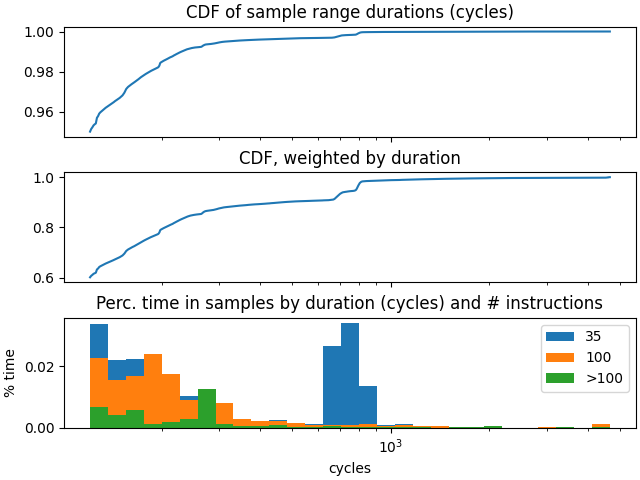

In [37]:
from matplotlib import pyplot as plt
import duckdb
import numpy
%matplotlib widget

with duckdb.connect(db_file) as con:
    # 1. calculate the cdf of timestamped range durations in cycles.
    # 2. plot the distributions as contour lines of instructions or IPC
    # 3. plot the cdf weighted by duration.  This displays cumulative time spent in
    # ranges of each duration, not simply frequency.

    con.execute('select * from range_cdf')
    range_data = con.fetchall()

    # only look at the top of the cdf.  Where p>.05
    cyc_count, cdf, weighted_cdf, *perc_insns = zip(*[
        t for t in range_data
        if t[1] > 0.95
        ])
    plt.close()
    fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, sharex=True, layout='constrained')
    ax1.semilogx(cyc_count, cdf)
    ax1.set_title('CDF of sample range durations (cycles)')
    ax2.semilogx(cyc_count, weighted_cdf)
    ax2.set_title('CDF, weighted by duration')

    min_cyc_count = min(cyc_count)

    con.execute("""--sql
with t1 as (
    SELECT
        cyc_count,
        insn_count,
        cast(insn_count as real) / cyc_count as ipc,
        CASE
            WHEN insn_count <= 35 THEN 0
            WHEN insn_count <= 100 THEN 1
            ELSE 2
        END AS insn_group
    from samples_for_cdf
    where cyc_count >= {min_cyc_count}
)
SELECT
    cyc_count,
    cast(count(*) FILTER (insn_group = 0) * cyc_count as real) /
        (select sum(cyc_count) from samples_for_cdf) as weighted_insn_count_0,
    cast(count(*) FILTER (insn_group = 1) * cyc_count as real) /
        (select sum(cyc_count) from samples_for_cdf) as weighted_insn_count_1,
    cast(count(*) FILTER (insn_group = 2) * cyc_count as real) /
        (select sum(cyc_count) from samples_for_cdf) as weighted_insn_count_2,
from t1
group by cyc_count
order by cyc_count
;""".format(min_cyc_count=min_cyc_count))
    range_data = con.df()
    print(range_data)
    bins=numpy.logspace(
        numpy.log10(numpy.min(cyc_count)),
        numpy.log10(numpy.max(cyc_count)),
        30)
    kwargs = {
        'data': range_data,
        'x': 'cyc_count',
        'bins': bins,
        #'density': True,
    }
    ax3.hist(weights='weighted_insn_count_0', label='35', **kwargs)
    ax3.hist(weights='weighted_insn_count_1', label='100', **kwargs)
    ax3.hist(weights='weighted_insn_count_2', label='>100', **kwargs)
    ax3.legend()
    ax3.set_title('Perc. time in samples by duration (cycles) and # instructions')
    ax3.set_ylabel("% time")
    ax3.set_xlabel("cycles")


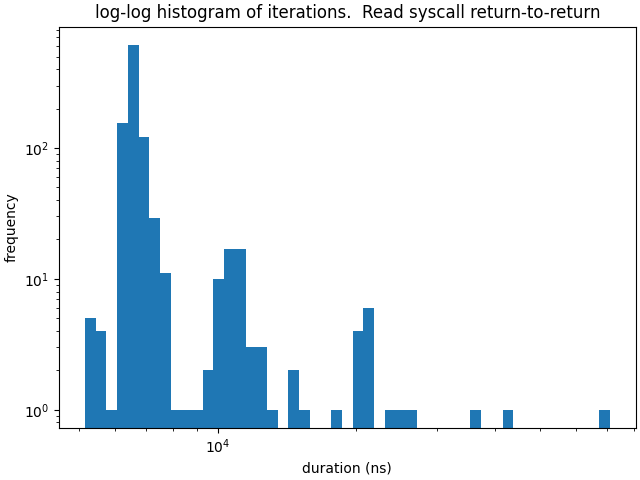

No such comm: 0c37f464ca8f4d42b20e156b126b8718
No such comm: 0c37f464ca8f4d42b20e156b126b8718
No such comm: 0c37f464ca8f4d42b20e156b126b8718
No such comm: 0c37f464ca8f4d42b20e156b126b8718
No such comm: 0c37f464ca8f4d42b20e156b126b8718
No such comm: 0c37f464ca8f4d42b20e156b126b8718
No such comm: 0c37f464ca8f4d42b20e156b126b8718
No such comm: 0c37f464ca8f4d42b20e156b126b8718
No such comm: 0c37f464ca8f4d42b20e156b126b8718
No such comm: 0c37f464ca8f4d42b20e156b126b8718


In [39]:
from matplotlib import pyplot as plt
import numpy
import duckdb
%matplotlib widget

# look at the distribution of iteration latency to see if any slowdown from
# perf/ipt is from individual long delays or consistent per-iteration delays

with duckdb.connect(db_file) as con:
    con.execute('''--sql
SELECT
    return_time,
    lag(return_time) OVER (ORDER BY return_time) AS lag_return_time,
    return_time - lag_return_time as latency_ns,
    syscall_kernel_name
FROM syscall_calls
WHERE
    syscall_kernel_name IN ('__x64_sys_recvfrom')
-- recall QUALIFY filters on window function results
QUALIFY lag_return_time IS NOT NULL
ORDER BY return_time 
;'''.format(end_ns=end_ns, start_ns=start_ns))
    event_data = con.df()

    min_bin = event_data['latency_ns'].min() * 0.99
    max_bin = event_data['latency_ns'].max() * 1.01
    bins=numpy.logspace(
        numpy.log10(min_bin),
        numpy.log10(max_bin),
        50)
    kwargs = {
        'data': event_data,
        'x': 'latency_ns',
        'bins': bins,
        'log': True,
    }

    plt.close()
    fig, ax1 = plt.subplots(
        #nrows=3,
        #sharex=True,
        layout='constrained')
    ax1.set_xscale('log')
    ax1.hist(**kwargs)
    ax1.set_title('log-log histogram of iterations.  Read syscall return-to-return')
    ax1.set_xlabel('duration (ns)')
    ax1.set_ylabel('frequency')